In [1]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
df.head()

,Ticker,Last_Price,Quantity,Position_Value
0,AAPL,258.059998,18.00,4645.079956
1,AMD,231.687607,18.00,4170.376923
2,ASML,989.070007,6.00,5934.420044
3,BNB-USD,1315.106201,13.09,17214.740173
4,BR50.MI,24.049999,213.00,5122.649837


In [2]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10

,Ticker,Last_Price,Quantity,Position_Value
5,BTC-USD,123355.679688,2.1571,266090.536654
16,META,719.145020,60.0000,43148.701172
7,EQQQ.DE,527.000000,39.0000,20553.000000
8,ETH-USD,4507.845215,4.3100,19428.812876
3,BNB-USD,1315.106201,13.0900,17214.740173
15,MC.PA,575.500000,22.0000,12661.000000
6,DOGE-USD,0.257870,40270.0000,10384.410042
12,IWDE.MI,105.660004,96.0000,10143.360352
21,RACE,478.019989,13.0000,6214.259857
22,TSLA,437.149292,14.0000,6120.090088


In [3]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# # some Ticker should be adjusted for the data source
# port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [4]:
port_list

['BTC-USD',
 'META',
 'EQQQ.DE',
 'ETH-USD',
 'BNB-USD',
 'MC.PA',
 'DOGE-USD',
 'IWDE.MI',
 'RACE',
 'TSLA']

In [5]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [6]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

df_stocks.head()

Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.761078,127.410179,57.299999,383.397308,208.494690,161.780365,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.288239,134.171707,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.288239,135.069366,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.288239,136.276779,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.288239,144.304153,57.060001,379.738556,211.297440,159.226593,30.102667


In [7]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

'\nThe plot visualizes the hierarchical clustering of assets \nbased on their historical return correlations. \nIt illustrates how clusters of assets are merged at each \nhierarchical level and can give us insight into the \ncorrelation structure within a portfolio. \nThe method takes asset returns and a clustering method \nto compute and plot the dendrogram.\n'

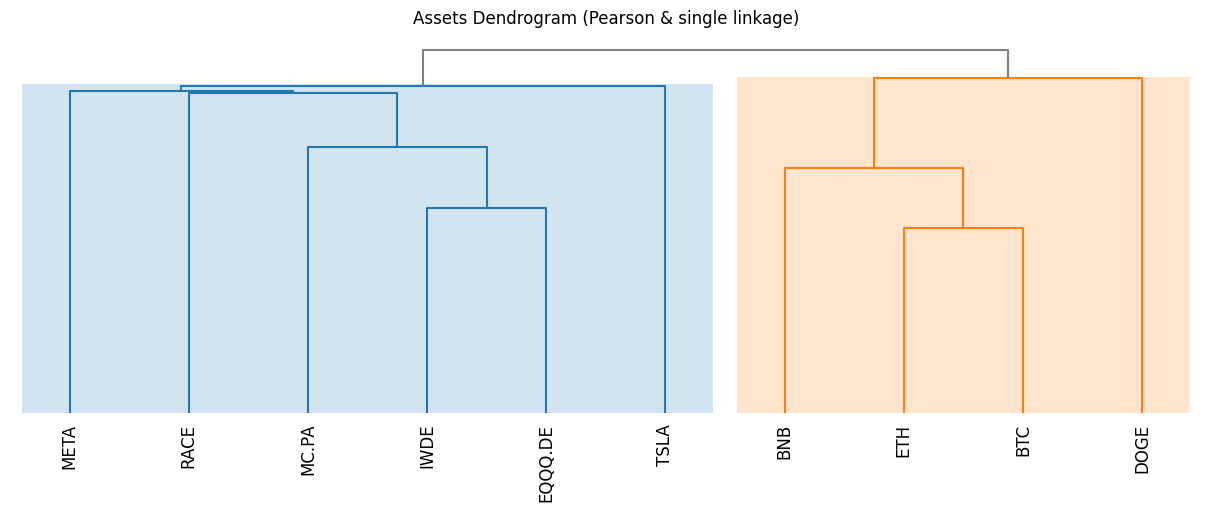

In [8]:
# list of assets
assets = returns.columns

# We can plot the dendrogram to visualize which assets 
# are clustered together.
ax = rp.plot_dendrogram(
    returns=returns,
    codependence="pearson",
    linkage="single",
    k=None,
    max_k=10,
    leaf_order=True,
    ax=None,
)

"""
The plot visualizes the hierarchical clustering of assets 
based on their historical return correlations. 
It illustrates how clusters of assets are merged at each 
hierarchical level and can give us insight into the 
correlation structure within a portfolio. 
The method takes asset returns and a clustering method 
to compute and plot the dendrogram.
"""

In [9]:
port = rp.HCPortfolio(returns=returns)
w = port.optimization(
    model="HRP",
    codependence="pearson",
    rm="MV",
    rf=0.05,
    linkage="single",
    max_k=10,
    leaf_order=True,
)

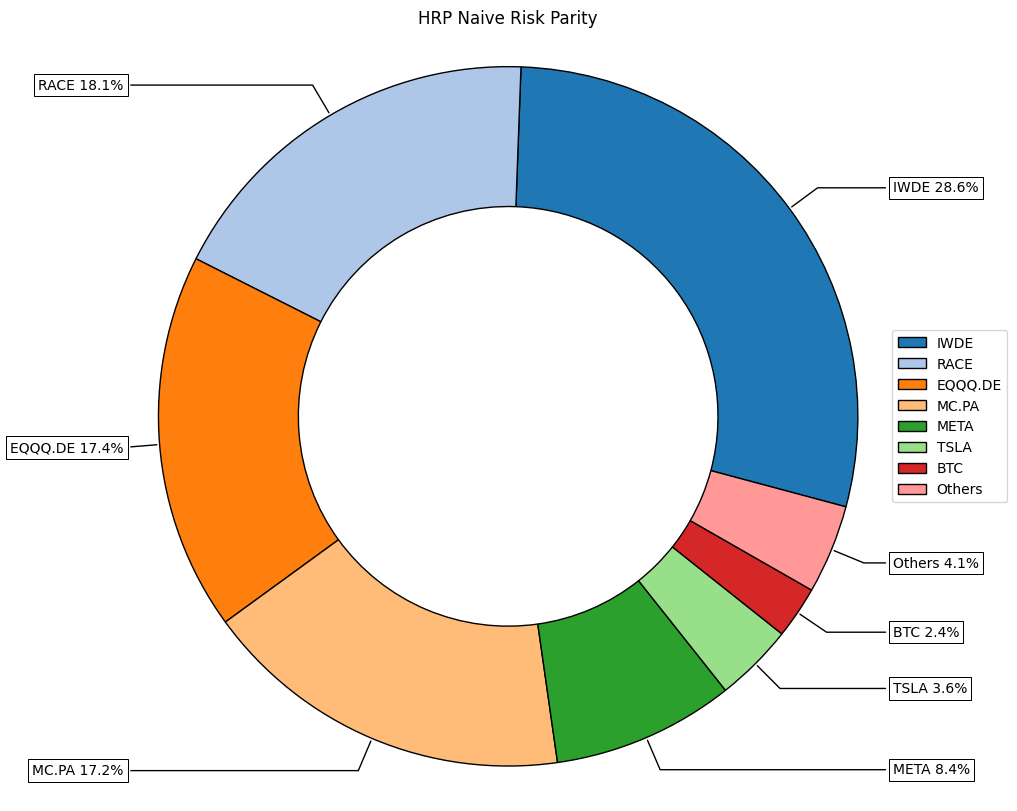

In [10]:
# This code generates a pie chart which with the weights of each asset.
ax = rp.plot_pie(
    w=w,
    title="HRP Naive Risk Parity",
    others=0.05,
    nrow=25,
    cmap="tab20",
    height=8,
    width=10,
    ax=None,
)

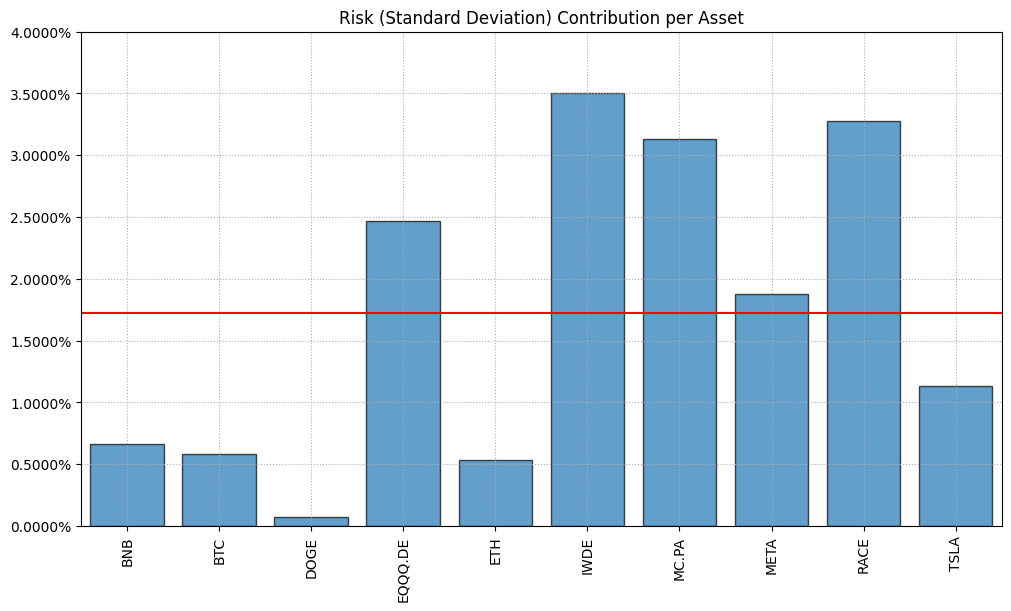

In [11]:
# We can also visualize the risk contribution of each asset.

ax = rp.plot_risk_con(
    w=w,
    cov=returns.cov(),
    returns=returns,
    rm="MV",
    rf=0,
    alpha=0.05,
    color="tab:blue",
    height=6,
    width=10,
    t_factor=252,
    ax=None,
)